# Antibody Response Pulse
https://github.com/blab/antibody-response-pulse/

### B-cells evolution --- cross-reactive antibody response after influenza virus infection or vaccination
### Adaptive immune response for repeated infection

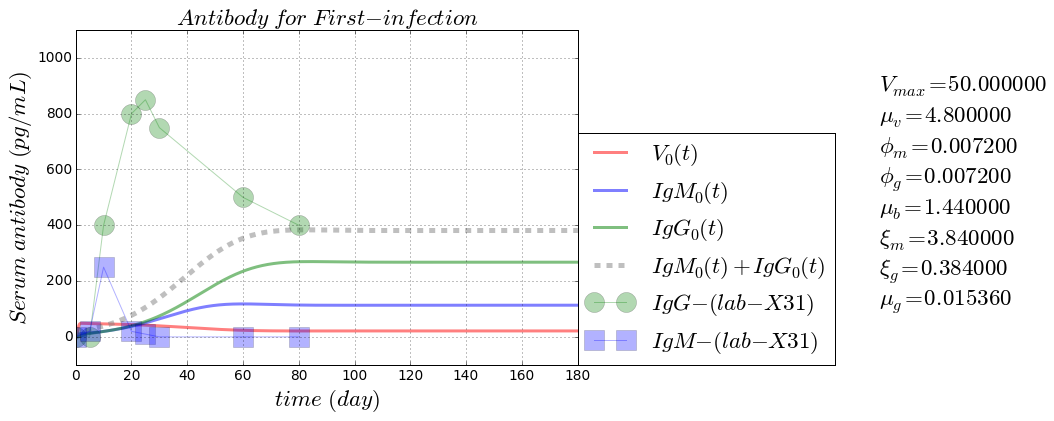

In [6]:
'''
author: Alvason Zhenhua Li
date:   04/09/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

AlvaFontSize = 23
AlvaFigSize = (9, 6)
numberingFig = 0

# plotting
dir_path = '/Users/al/Desktop/GitHub/antibody-response-pulse/bcell-array/figure'
file_name = 'Virus-Bcell-IgM-IgG'
figure_name = '-equation'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)



# define the V-M-G partial differential equations
def dVdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dV_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    for xn in range(x_totalPoint):
        dV_dt_array[xn] = +inRateV*V[xn]*(1 - V[xn]/maxV) - killRateVm*M[xn]*V[xn] - killRateVg*G[xn]*V[xn]
    return(dV_dt_array)

def dBdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dB_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    for xn in range(x_totalPoint):
        dB_dt_array[xn] = +inRateB*V[xn]*(1 - V[xn]/maxV) + (actRateBm + actRateBg)/10*B[xn]*V[xn] - outRateB*B[xn]
    return(dB_dt_array)

def dMdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dM_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    for xn in range(x_totalPoint):
        dM_dt_array[xn] = +inRateM*B[xn] - consumeRateM*M[xn]*V[xn] - outRateM*M[xn]
    return(dM_dt_array)

def dGdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dG_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    for xn in range(x_totalPoint):
        dG_dt_array[xn] = +inRateG*B[xn] - consumeRateG*G[xn]*V[xn] - outRateG*G[xn]
    return(dG_dt_array)

# define RK4 for an array (3, n) of coupled differential equations
def AlvaRungeKutta4ArrayXT(pde_array, startingOut_Value, minX_In, maxX_In, totalGPoint_X, minT_In, maxT_In, totalGPoint_T):
    # primary size of pde equations
    outWay = pde_array.shape[0]
    # initialize the whole memory-space for output and input
    inWay = 1; # one layer is enough for storing "x" and "t" (only two list of variable)
    # define the first part of array as output memory-space
    gridOutIn_array = np.zeros([outWay + inWay, totalGPoint_X, totalGPoint_T])
    # loading starting output values
    for i in range(outWay):
        gridOutIn_array[i, :, :] = startingOut_Value[i, :, :]
    # griding input X value  
    gridingInput_X = np.linspace(minX_In, maxX_In, num = totalGPoint_X, retstep = True)
    # loading input values to (define the final array as input memory-space)
    gridOutIn_array[-inWay, :, 0] = gridingInput_X[0]
    # step-size (increment of input X)
    dx = gridingInput_X[1]
    # griding input T value  
    gridingInput_T = np.linspace(minT_In, maxT_In, num = totalGPoint_T, retstep = True)
    # loading input values to (define the final array as input memory-space)
    gridOutIn_array[-inWay, 0, :] = gridingInput_T[0]
    # step-size (increment of input T)
    dt = gridingInput_T[1]
    # starting
    # initialize the memory-space for local try-step 
    dydt1_array = np.zeros([outWay, totalGPoint_X])
    dydt2_array = np.zeros([outWay, totalGPoint_X])
    dydt3_array = np.zeros([outWay, totalGPoint_X])
    dydt4_array = np.zeros([outWay, totalGPoint_X])
    # initialize the memory-space for keeping current value
    currentOut_Value = np.zeros([outWay, totalGPoint_X])
    for tn in range(totalGPoint_T - 1):
        # setting virus1 = 0 if virus1 < 1
        if gridOutIn_array[0, 0, tn] < 1.0:
            gridOutIn_array[0, 0, tn] = 0.0
        # keep initial value at the moment of tn
        currentOut_Value[:, :] = np.copy(gridOutIn_array[:-inWay, :, tn])
        currentIn_T_Value = np.copy(gridOutIn_array[-inWay, 0, tn])
        # first try-step
        for i in range(outWay):
            for xn in range(totalGPoint_X):
                dydt1_array[i, xn] = pde_array[i](gridOutIn_array[:, :, tn])[xn] # computing ratio   
        gridOutIn_array[:-inWay, :, tn] = currentOut_Value[:, :] + dydt1_array[:, :]*dt/2 # update output
        gridOutIn_array[-inWay, 0, tn] = currentIn_T_Value + dt/2 # update input
        # second half try-step
        for i in range(outWay):
            for xn in range(totalGPoint_X):
                dydt2_array[i, xn] = pde_array[i](gridOutIn_array[:, :, tn])[xn] # computing ratio   
        gridOutIn_array[:-inWay, :, tn] = currentOut_Value[:, :] + dydt2_array[:, :]*dt/2 # update output
        gridOutIn_array[-inWay, 0, tn] = currentIn_T_Value + dt/2 # update input
        # third half try-step
        for i in range(outWay):
            for xn in range(totalGPoint_X):
                dydt3_array[i, xn] = pde_array[i](gridOutIn_array[:, :, tn])[xn] # computing ratio   
        gridOutIn_array[:-inWay, :, tn] = currentOut_Value[:, :] + dydt3_array[:, :]*dt # update output
        gridOutIn_array[-inWay, 0, tn] = currentIn_T_Value + dt # update input
        # fourth try-step
        for i in range(outWay):
            for xn in range(totalGPoint_X):
                dydt4_array[i, xn] = pde_array[i](gridOutIn_array[:, :, tn])[xn] # computing ratio 
        # solid step (update the next output) by accumulate all the try-steps with proper adjustment
        gridOutIn_array[:-inWay, :, tn + 1] = currentOut_Value[:, :] + dt*(dydt1_array[:, :]/6 
                                                                                      + dydt2_array[:, :]/3 
                                                                                      + dydt3_array[:, :]/3 
                                                                                      + dydt4_array[:, :]/6)
        # restore to initial value
        gridOutIn_array[:-inWay, :, tn] = np.copy(currentOut_Value[:, :])
        gridOutIn_array[-inWay, 0, tn] = np.copy(currentIn_T_Value)
        # end of loop
    return (gridOutIn_array[:-inWay, :])


# Experimental lab data from OAS paper
gT_lab = np.array([0, 5, 10, 20, 25, 30, 60, 80])
gIgG_lab = np.array([0, 0, 4, 8, 8.5, 7.5, 5, 4])*10**2 
gIgM_lab = np.array([0, 0.2, 2.5, 0.2, 0.1, 0, 0, 0])*10**2

# setting parameter
timeUnit = 'day'
if timeUnit == 'hour':
    hour = float(1); day = float(24); 
elif timeUnit == 'day':
    day = float(1); hour = float(1)/24; 
    
maxV = float(50) # max virus/micro-liter
inRateV = 0.2/hour # in-rate of virus
killRateVm = 0.0003/hour # kill-rate of virus by antibody-IgM
killRateVg = killRateVm # kill-rate of virus by antibody-IgG

inRateB = 0.06/hour # in-rate of B-cell
outRateB = inRateB/8 # out-rate of B-cell
actRateBm = killRateVm # activation rate of naive B-cell
actRateBg = killRateVg # activation rate of memory B-cell

inRateM = 0.16/hour # in-rate of antibody-IgM from naive B-cell
outRateM = inRateM/1  # out-rate of antibody-IgM from naive B-cell
consumeRateM = killRateVm # consume-rate of antibody-IgM by cleaning virus

inRateG = inRateM/10 # in-rate of antibody-IgG from memory B-cell
outRateG = outRateM/250 # out-rate of antibody-IgG from memory B-cell
consumeRateG = killRateVg  # consume-rate of antibody-IgG by cleaning virus

# time boundary and griding condition
minT = float(0)
maxT = float(180*day)
totalGPoint_T = int(3*10**3 + 1)
gridT = np.linspace(minT, maxT, totalGPoint_T)
spacingT = np.linspace(minT, maxT, num = totalGPoint_T, retstep = True)
gridT = spacingT[0]
dt = spacingT[1]

# space boundary and griding condition
minX = float(0)
maxX = float(1)
totalGPoint_X = int(1 + 1)
gridX = np.linspace(minX, maxX, totalGPoint_X)
gridingX = np.linspace(minX, maxX, num = totalGPoint_X, retstep = True)
gridX = gridingX[0]
dx = gridingX[1]
gridV_array = np.zeros([totalGPoint_X, totalGPoint_T])
gridB_array = np.zeros([totalGPoint_X, totalGPoint_T])
gridM_array = np.zeros([totalGPoint_X, totalGPoint_T])
gridG_array = np.zeros([totalGPoint_X, totalGPoint_T])
# initial output condition
gridV_array[0, 0] = float(1)
gridB_array[0, 0] = float(0)
gridM_array[0, 0] = float(0)
gridG_array[0, 0] = float(0)
# Runge Kutta numerical solution
pde_array = np.array([dVdt_array, dBdt_array, dMdt_array, dGdt_array])
startingOut_Value = np.array([gridV_array, gridB_array, gridM_array, gridG_array])
gridOut_array = AlvaRungeKutta4ArrayXT(pde_array, startingOut_Value, minX, maxX, totalGPoint_X, minT, maxT, totalGPoint_T)
# plotting
gridV = gridOut_array[0]  
gridB = gridOut_array[1] 
gridM = gridOut_array[2]
gridG = gridOut_array[3]

figure_name = '-first-infection'
figure_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)
numberingFig = numberingFig + 1
ymin = -100
ymax = 1100
for i in range(1):
    plt.figure(numberingFig, figsize = AlvaFigSize)
    plt.plot(gridT, gridV[i], color = 'red', label = r'$ V_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridM[i], color = 'blue', label = r'$ IgM_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridG[i], color = 'green', label = r'$ IgG_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridM[i] + gridG[i], color = 'gray', linewidth = 5.0, alpha = 0.5, linestyle = 'dashed'
             , label = r'$ IgM_{%i}(t) + IgG_{%i}(t) $'%(i, i))
    plt.plot(gT_lab, gIgG_lab, marker = 'o', markersize = 20, alpha = 0.3, color = 'green', label = r'$ IgG-(lab-X31) $')
    plt.plot(gT_lab, gIgM_lab, marker = 's', markersize = 20, alpha = 0.3, color = 'blue', label = r'$ IgM-(lab-X31) $')
    plt.grid(True, which = 'both')
    plt.title(r'$ Antibody \ for \ First-infection $', fontsize = AlvaFontSize)
    plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Serum \ antibody \ (pg/mL) $', fontsize = AlvaFontSize)
    plt.xticks(fontsize = AlvaFontSize*0.6)
    plt.yticks(fontsize = AlvaFontSize*0.6) 
    plt.text(maxT*16.0/10, ymax*8.0/10, r'$ V_{max} = %f $'%(maxV), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*7.0/10, r'$ \mu_{v} = %f $'%(inRateV), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*6.0/10, r'$ \phi_{m} = %f $'%(killRateVm), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*5.0/10, r'$ \phi_{g} = %f $'%(killRateVg), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*4.0/10, r'$ \mu_{b} = %f $'%(inRateB), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*3.0/10, r'$ \xi_{m} = %f $'%(inRateM), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*2.0/10, r'$ \xi_{g} = %f $'%(inRateG), fontsize = AlvaFontSize)
    plt.text(maxT*16.0/10, ymax*1.0/10, r'$ \mu_{g} = %f $'%(outRateG), fontsize = AlvaFontSize)
    plt.ylim(ymin, ymax)
    plt.legend(loc = (1, 0), fontsize = AlvaFontSize)
    plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
    plt.show()

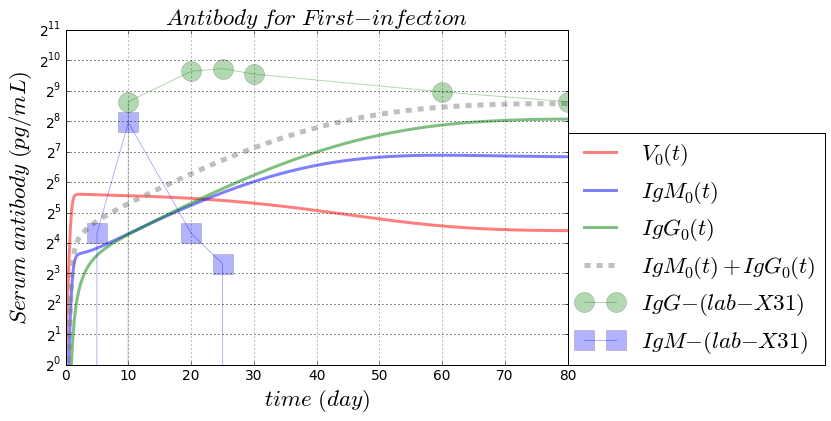

In [5]:
numberingFig = numberingFig + 1
ymin = -100
ymax = 1100
for i in range(1):
    plt.figure(numberingFig, figsize = AlvaFigSize)
    plt.plot(gridT, gridV[i], color = 'red', label = r'$ V_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridM[i], color = 'blue', label = r'$ IgM_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridG[i], color = 'green', label = r'$ IgG_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gridT, gridM[i] + gridG[i], color = 'gray', linewidth = 5.0, alpha = 0.5, linestyle = 'dashed'
             , label = r'$ IgM_{%i}(t) + IgG_{%i}(t) $'%(i, i))
    plt.plot(gT_lab, gIgG_lab, marker = 'o', markersize = 20, alpha = 0.3, color = 'green', label = r'$ IgG-(lab-X31) $')
    plt.plot(gT_lab, gIgM_lab, marker = 's', markersize = 20, alpha = 0.3, color = 'blue', label = r'$ IgM-(lab-X31) $')
    plt.grid(True, which = 'both')
    plt.title(r'$ Antibody \ for \ First-infection $', fontsize = AlvaFontSize)
    plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Serum \ antibody \ (pg/mL) $', fontsize = AlvaFontSize)
    plt.xticks(fontsize = AlvaFontSize*0.6)
    plt.yticks(fontsize = AlvaFontSize*0.6) 

    plt.ylim([2**0, 2**11])
    plt.yscale('log', basey = 2)
    plt.legend(loc = (1, 0), fontsize = AlvaFontSize)
    plt.show()

In [3]:
inRateG

0.384